In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import sentencepiece as spm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_file = '/home/henry/Documents/wrapper/transformer-evolution/transformer/kowiki.model'
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

# 1. vocab
- Word Piece Model
    - 단어와 subword unit으로 나눔
    - 단어의 시작을 특수문자; subword unit은 space로 나눔;

In [213]:
# data_dir = '/home/henry/Documents/wrapper/transformer-evolution/ratings_train.txt'
# lines = []; outputs = [];
# with open(data_dir, "r") as f:
#     for idx, line in enumerate(f):
#         if idx == 0:
#             continue
#         if idx == 4:
#             break
#         temp = line.split()
#         lines.append(' '.join(temp[1:-1]))
#         outputs.append(temp[-1])

In [214]:
lines = [
  "겨울은 추워요.",
  "감기 조심하세요."
]

In [5]:
inputs = []
for line in lines:
    pieces = vocab.encode_as_pieces(line)
    ids = vocab.encode_as_ids(line)
    inputs.append(torch.tensor(ids))
    print(pieces)

['▁겨울', '은', '▁추', '워', '요', '.']
['▁감', '기', '▁조', '심', '하', '세', '요', '.']


In [6]:
print(inputs)

[tensor([3091, 3604,  206, 3958, 3760, 3590]), tensor([ 212, 3605,   53, 3832, 3596, 3682, 3760, 3590])]


In [7]:
inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
print(inputs, inputs.size())

tensor([[3091, 3604,  206, 3958, 3760, 3590,    0,    0],
        [ 212, 3605,   53, 3832, 3596, 3682, 3760, 3590]]) torch.Size([2, 8])


# 2. embedding

### 2.1. word embedding

In [8]:
n_vocab = len(vocab)
d_hidn = 128
nn_emb = nn.Embedding(num_embeddings=n_vocab, embedding_dim=d_hidn)

# torch.Size([2, 8, 128])
input_embs = nn_emb(inputs) # 임베딩 레이어에 input 

### 2.2. position embedding
- $PE(pos, 2i) = sin(\frac{pos}{1E+4^{2i / d_{model}}}),$
- $PE(pos, 2i+1) = cos(\frac{pos}{1E+4^{2i / d_{model}}}),$
- i: embedding vector에서 idx
- pos: sentence에서 position

In [9]:
def get_sinusoid_encoding_table(n_seq, d_hidn):
    
    def _cal_angle(pos, i_hidn):
        return pos / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    
    def _get_posi_angle_vec(pos):
        # sentence의 pos 하나(즉 단어 하나)에 대해 embedding; feature1, feature2, ...., feature128 
        # 즉, sequence의 각 position을 128차원으로 position embedding
        # 예컨대, 첫번째 자리 pos embedding은 정해져 있으므로, 첫번째 자리에 어떤 단어가 들어오든, 
        # 해당 pos embedding이 word embedding에 더해짐
        return [_cal_angle(pos, i_hidn) for i_hidn in range(d_hidn)]
    
    # seq_pos: Word의 sentence 내의 위치 = i
    sinusoid_table = np.array([_get_posi_angle_vec(seq_pos) for seq_pos in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 0::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

In [10]:
# 64개 단어가 하나의 sentence; 128차원 posion임베딩;
n_seq = 64
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)
print(pos_encoding.shape)

(64, 128)


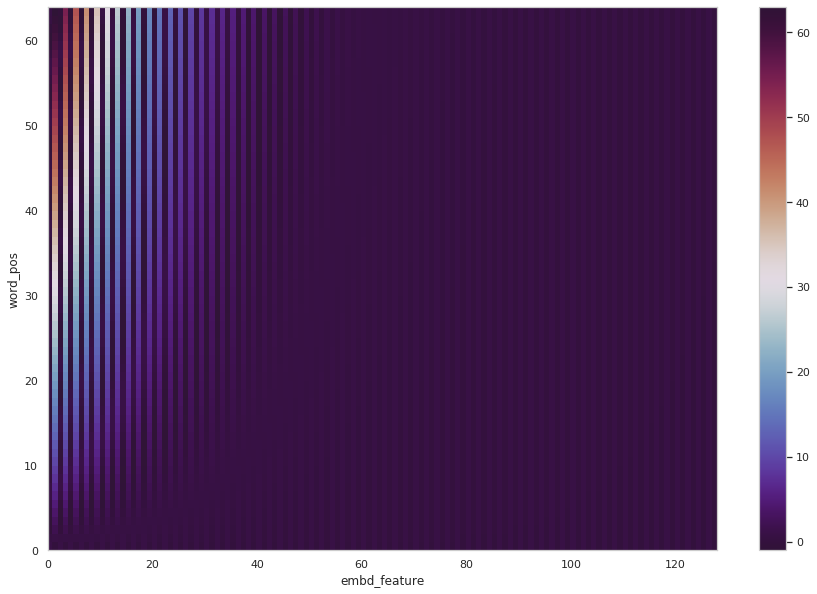

In [11]:
# row: sentence에서 위치(pos)
%matplotlib inline
plt.figure(figsize=(15,10))
plt.pcolormesh(pos_encoding, cmap='twilight_shifted')
plt.xlabel('embd_feature')
plt.xlim([0, d_hidn])
plt.ylabel('word_pos')
plt.colorbar()
plt.show()

### 2.3. pos embd + word embd
- 의문: pos embd도 train 필요?

In [12]:
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True) # layer; lookup table
# >> Embedding(64, 128)

position = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype)
# >> tensor([0, 1, 2, 3, 4, 5, 6, 7])
position = position.expand(inputs.size())
# >> tensor([[0, 1, 2, 3, 4, 5, 6, 7],
#            [0, 1, 2, 3, 4, 5, 6, 7]])
position = position.contiguous() + 1
# >> tensor([[1, 2, 3, 4, 5, 6, 7, 8],
#            [1, 2, 3, 4, 5, 6, 7, 8]])

In [13]:
pos_mask = inputs.eq(0) # find elems equal to 0 = pad
# tensor([[False, False, False, False, False, False,  True,  True],
#         [False, False, False, False, False, False, False, False]])

position.masked_fill_(pos_mask, 0) # pad는 position 정보도 주지 않음
# tensor([[1, 2, 3, 4, 5, 6, 0, 0],
#         [1, 2, 3, 4, 5, 6, 7, 8]])
pos_embs = nn_pos(position)
# pos_embs.shape 
# >> torch.Size([2, 8, 128]) # batch_size, sequence_len, emb_dim

In [14]:
print(inputs) # embeddimg idx coresponding to the word
print(position)
print(pos_embs.size())

input_vector = input_embs + pos_embs
print(input_vector.size())

tensor([[3091, 3604,  206, 3958, 3760, 3590,    0,    0],
        [ 212, 3605,   53, 3832, 3596, 3682, 3760, 3590]])
tensor([[1, 2, 3, 4, 5, 6, 0, 0],
        [1, 2, 3, 4, 5, 6, 7, 8]])
torch.Size([2, 8, 128])
torch.Size([2, 8, 128])


In [15]:
a = np.random.randint(1,10, (100,))
b = np.random.randint(1,10, (100,))
a.dot(b)

2427

# 3. Scale Dot Product Attention
$$
Attention(Q, K, V) = softmax_k(\dfrac{QK^T}{\sqrt{d_k}})V
$$
- 왜 scale? 
    - d_k는 key vector의 dim. 
    - depth가 깊다면, $QK^T$ 값이 커짐
> "The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax."
(https://www.tensorflow.org/tutorials/text/transformer)

- detail: 내적은 두 벡터의 크기 * 둘 간의 cosin angle
    - $cos \theta = \dfrac{A \dot B}{|A||B|}$
    - key dim으로 정규화하면 값이 너무 커지는 것을 방지할 수 있음(https://physics.stackexchange.com/questions/252086/dot-product-approaches-zero-as-the-magnitude-of-the-vectors-increase)
- key, query, value? 
    - 기존 attention 모델은, decoder time step t의 hidden state와 encoder의 모든 time step의 hidden state간의 score를 산출. 
    - 그리고 그 score를 다시 encoder의 hidden state에 곱하여 weight를 주고, 합산하여 context vector를 산출. 
    - 위 context vector는, time step t의 hidden state와 concat.
    - concat된 vector는 feedforward 통과하여 time step t의 출력값
    - 이를 transformer와 비교해보자면, score은 **value**(but value vector 따로 있음), decoder의 hidden state는 **query**, encoder의 hidden state는 **key**에 해당.
    
>  "Traditionally, the attention weights were the relevance of the encoder hidden states (values) in processing the decoder state (query) and were calculated based on the encoder hidden states (keys) and the decoder hidden state (query)."(https://mlexplained.com/2017/12/29/attention-is-all-you-need-explained/)

In [16]:
Q = input_vector
K = input_vector
V = input_vector
inputs.eq(0) # 0과 동일한 indice
inputs.eq(0).unsqueeze(1) # dim에 1차원 추가
# >> torch.Size([2, 1, 8])

tensor([[[False, False, False, False, False, False,  True,  True]],

        [[False, False, False, False, False, False, False, False]]])

In [17]:
inputs.eq(0).size()

torch.Size([2, 8])

In [18]:
inputs.unsqueeze(1).size()

torch.Size([2, 1, 8])

- attn_mask: key padding indice 마스킹

In [19]:
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), Q.size(1))
# >> torch.Size([2, 8, 8])
print(inputs.eq(0).unsqueeze(1))
print(attn_mask)

tensor([[[False, False, False, False, False, False,  True,  True]],

        [[False, False, False, False, False, False, False, False]]])
tensor([[[False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True]],

        [[False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, Fals

- Q.k^T

In [20]:
scores = torch.matmul(Q, K.transpose(-1, -2))
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[195.2584,  56.8679,  44.3942,  62.4791,  53.6402,  66.9539,  57.5793,
          57.5793],
        [ 56.8679, 199.4895,  71.4400,  50.1359,  74.5325,  83.2698,  33.6057,
          33.6057],
        [ 44.3942,  71.4400, 194.6201,  87.3249, 113.1396, 118.8177,  45.8072,
          45.8072],
        [ 62.4791,  50.1359,  87.3249, 234.3755, 133.8546, 134.7569,  38.9334,
          38.9334],
        [ 53.6402,  74.5325, 113.1396, 133.8546, 277.1770, 153.3280,  13.3131,
          13.3131],
        [ 66.9539,  83.2698, 118.8177, 134.7569, 153.3280, 283.6367,  48.7106,
          48.7106],
        [ 57.5793,  33.6057,  45.8072,  38.9334,  13.3131,  48.7106, 208.7577,
         208.7577],
        [ 57.5793,  33.6057,  45.8072,  38.9334,  13.3131,  48.7106, 208.7577,
         208.7577]], grad_fn=<SelectBackward>)


### 3.1. scale
- $1/\sqrt{d_k}$
- d_head?

In [21]:
d_head = 64
scores = scores.mul(1/d_head**0.5)

### 3.2 mask
- score matrix
    - col: key
    - row: query

In [22]:
scores.masked_fill_(attn_mask, -1e9)
# torch.Size([2, 8, 8])

tensor([[[ 2.4407e+01,  7.1085e+00,  5.5493e+00,  7.8099e+00,  6.7050e+00,
           8.3692e+00, -1.0000e+09, -1.0000e+09],
         [ 7.1085e+00,  2.4936e+01,  8.9300e+00,  6.2670e+00,  9.3166e+00,
           1.0409e+01, -1.0000e+09, -1.0000e+09],
         [ 5.5493e+00,  8.9300e+00,  2.4328e+01,  1.0916e+01,  1.4142e+01,
           1.4852e+01, -1.0000e+09, -1.0000e+09],
         [ 7.8099e+00,  6.2670e+00,  1.0916e+01,  2.9297e+01,  1.6732e+01,
           1.6845e+01, -1.0000e+09, -1.0000e+09],
         [ 6.7050e+00,  9.3166e+00,  1.4142e+01,  1.6732e+01,  3.4647e+01,
           1.9166e+01, -1.0000e+09, -1.0000e+09],
         [ 8.3692e+00,  1.0409e+01,  1.4852e+01,  1.6845e+01,  1.9166e+01,
           3.5455e+01, -1.0000e+09, -1.0000e+09],
         [ 7.1974e+00,  4.2007e+00,  5.7259e+00,  4.8667e+00,  1.6641e+00,
           6.0888e+00, -1.0000e+09, -1.0000e+09],
         [ 7.1974e+00,  4.2007e+00,  5.7259e+00,  4.8667e+00,  1.6641e+00,
           6.0888e+00, -1.0000e+09, -1.0000e+09]],

### 3.3. softmax
- https://stackoverflow.com/questions/49036993/pytorch-softmax-what-dimension-to-use
- https://blog.csdn.net/qq_36097393/article/details/89319643
- dim=-1이면 가장 높은 차원 기준 softmax

In [23]:
attn_prob = nn.Softmax(dim=-1)(scores) # dim 유지
print(attn_prob.size())

torch.Size([2, 8, 8])


In [24]:
data = torch.randn(size=(2,2,3,4,5))
data.size()

torch.Size([2, 2, 3, 4, 5])

In [25]:
nn.Softmax(dim=-1)(data).sum(dim=4)

tensor([[[[1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000]]],


        [[[1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000]]]])

### 3.4. attn_prov * V 

In [26]:
context = torch.matmul(attn_prob, V)
print(context.shape)

torch.Size([2, 8, 128])


# 4. Multi-Head attn
- d_hidn = embedding layer 아웃풋의 dim
    - embedding dim
- d_head = Q, K, V의 dim
    - embedding된 input값이
- d_hidn > d_head: 연산량 감소하기 위함 eg. 128 > 64

In [27]:
Q = input_vector
K = input_vector
V = input_vector
Q.shape

torch.Size([2, 8, 128])

- input을 multi head로 복제

In [28]:
batch_size = Q.size(0)
d_hidn = 128 # embedding dim
d_head = 64 # K, Q, V의 dim
n_head = 2

# linear feed forward layer
W_Q = nn.Linear(d_hidn, n_head * d_head)
W_K = nn.Linear(d_hidn, n_head * d_head)
W_V = nn.Linear(d_hidn, n_head * d_head)

### 4.1. multi-head K, Q, V input

In [29]:
# bs, n_seq, n_head, d_head
# torch.Size([2, 8, 2, 64])
W_Q(Q).view(batch_size, -1, n_head, d_head).shape
# torch.Size([2, 2, 8, 64]) 
W_Q(Q).view(batch_size, -1, n_head, d_head).transpose(1,2).shape

torch.Size([2, 2, 8, 64])

In [30]:
# (bs, n_head, n_seq, d_head)
Qs = W_Q(Q).view(batch_size, -1, n_head, d_head).transpose(1, 2)
Ks = W_K(K).view(batch_size, -1, n_head, d_head).transpose(1, 2)
Vs = W_V(V).view(batch_size, -1, n_head, d_head).transpose(1, 2)
Vs.shape

torch.Size([2, 2, 8, 64])

### 4.2. multi-head attn mask

In [31]:
# torch.Size([2, 8, 8]) -> torch.size([2, 2, 8, 8])
attn_mask = attn_mask.unsqueeze(1).repeat(1, n_head, 1, 1)

In [32]:
# torch.Size([2, 2, 8, 64]) * torch.Size([2, 2, 64, 8])
# output: torch.Size([2, 2, 8, 8])
scores = torch.matmul(Qs, Ks.transpose(-1, -2))
scores = scores.masked_fill(attn_mask, -np.inf)

# bs, n_head, [n_q_seq, n_k_seq]
# torch.Size([2, 2, 8, 8])
attn_prob = nn.Softmax(dim=-1)(scores)

# bs, n_head, n_q_seq, d_v
# torch.Size([2, 2, 8, 64])
context = torch.matmul(attn_prob, Vs)

### 4.3. concat

In [33]:
# transpose: bs, n_q_seq, n_head, d_v
# view: bs, n_q_seq, n_head * d_v
# -> torch.Size([2, 8, 128])
context = context\
.transpose(1, 2)\
.contiguous()\
.view(batch_size, -1, n_head * d_head)

# 5. output

In [34]:
# torch.Size([2, 8, 128])
# bs, [n_q_seq, n_hidn] <- embedding된 input size와 동일
enc_output = nn.Linear(n_head * d_head, d_hidn)(context)

# 6. feedforward
### 6.1. 1st linear feedforward

In [35]:
conv1 = nn.Conv1d(in_channels=d_hidn, \
                  out_channels=d_hidn * 4, kernel_size=1)

In [36]:
# bs, [n_hidn, n_q_seq]
# torch.Size([2, 128, 8])
enc_output.transpose(1,2).shape

# torch.Size([2, 512, 8])
enc_output = conv1(enc_output.transpose(1,2))

### 6.2. activation

In [37]:
enc_output = F.gelu(enc_output)

### 6.3. 2nd linear feedforward

In [38]:
conv2 = nn.Conv1d(in_channels=d_hidn * 4, \
                  out_channels=d_hidn, \
                  kernel_size=1)
# torch.Size([2, 128, 8])
enc_output = conv2(enc_output)

# 7. Encoder class

In [3]:
from types import SimpleNamespace
config = dict({
    "n_enc_vocab": len(vocab),
    "n_dec_vocab": len(vocab),
    "n_enc_seq": 256,
    "n_dec_seq": 256,
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12,
    "n_output": 2
})
print(config)
config = SimpleNamespace(**config)

{'n_enc_vocab': 8007, 'n_dec_vocab': 8007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12, 'n_output': 2}


- common class

In [4]:
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table

def get_attn_pad_mask(seq_q, seq_k, i_pad):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(i_pad).unsqueeze(1).expand(batch_size, len_q, len_k)  # <pad>
    return pad_attn_mask

def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super(MultiHeadAttention, self).__init__()
        self.config = config

        self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(self.config)
        self.linear = nn.Linear(self.config.n_head * self.config.d_head, self.config.d_hidn)
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        output = self.dropout(output)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

In [6]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_ff, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        output = self.dropout(output)
        # (bs, n_seq, d_hidn)
        return output

In [7]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dropout = nn.Dropout(config.dropout)
        self.scale = 1 / (self.config.d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        attn_prob = self.dropout(attn_prob)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

- encoder class

In [8]:
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, inputs, attn_mask):
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        att_outputs, attn_prob = self.self_attn(inputs, inputs, inputs, attn_mask)
        att_outputs = self.layer_norm1(inputs + att_outputs)
        # (bs, n_enc_seq, d_hidn)
        ffn_outputs = self.pos_ffn(att_outputs)
        ffn_outputs = self.layer_norcm2(ffn_outputs + att_outputs)
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        return ffn_outputs, attn_prob

In [9]:
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.enc_emb = nn.Embedding(self.config.n_enc_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_enc_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([EncoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, inputs):
        positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
        pos_mask = inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)

        # (bs, n_enc_seq, d_hidn)
        outputs = self.enc_emb(inputs) + self.pos_emb(positions)

        # (bs, n_enc_seq, n_enc_seq)
        attn_mask = get_attn_pad_mask(inputs, inputs, self.config.i_pad)

        attn_probs = []
        for layer in self.layers:
            # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
            outputs, attn_prob = layer(outputs, attn_mask)
            attn_probs.append(attn_prob)
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        return outputs, attn_probs

# 8. Decoder class

In [36]:
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        
        self.dec_enc_attn = MultiHeadAttention(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm.epsilon)
        
        self.pos_feedforward = PoswiseFeedForwardNet(self.config)
        self.layer_norm3 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        
    def forward(self, dec_inputs, enc_outputs, self_attn_mask, dec_enc_attn_mask):
        # MultiHeadAttention: forward(self, Q, K, V, attn_mask)
        
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq)
        self_attn_outputs, self_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, self_attn_mask) 
        self_attn_outputs = self.layer_norm1(dec_inputs + self_attn_outputs) # LaterNorm(residual)
        
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_enc_seq)
        dec_enc_attn_outputs, dec_enc_attn_prob = self.dec_enc_attn(self_attn_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_enc_attn_outputs = self.layer_norm2(self_attn_outputs + dec_enc_attn_outputs) # LaterNorm(residual)
        
        # (bs, n_dec_seq, d_hidn)
        ffn_outputs = self.pos_feedforward(dec_enc_attn_outputs)
        ffn_outputs = self.layer_norm3(dec_enc_attn_outputs + ffn_outputs)
        
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq), (bs, n_head, n_dec_seq, n_enc_seq)
        return ffn_outputs, self_attn_prob, dec_enc_attn_prob

In [37]:
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.dec_emb = nn.Embedding(self.config.n_dec_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_dec_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)
        self.layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(self.config.n_layer)])
        
    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        position = torch.arange(dec_inputs.size(1), device=dec_inputs.device, dtype=dec_inputs.dtype)\
                        .expands(dec_inputs.size(0), dec_inputs.size(1)).contiguouse() + 1
        pos_mask = dec_inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)
        
        # (bs, n_dec_seq, d_hidn)
        dec_outputs = self.dec_emb(dec_inputs) + self.pos_emb(positions)
        
        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.config.i_pad) # get_attn_pad_mask(seq_q, seq_k, i_pad)
        dec_attn_decoder_mask = get_attn_decoder_mask(dec_inputs) # 대각선 기준 위 mask
        
        dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0)
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs, self.config.i_pad)
        
        self_attn_probs, dec_enc_attn_probs = [], []
        for layer in self.layers:
            # (bs, n_dec_seq, d_hidn), (bs, n_dec_seq, n_dec_seq), (bs, d_dec_seq, n_enc_seq)
            dec_outputs, self_attn_prob, dec_enc_attn_prob = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            self_attn_probs.append(self_attn_prob)
            dec_enc_attn_probs.append(dec_enc_attn_prob)
        return dec_outputs, self_attn_probs, dec_enc_attn_probs

In [38]:
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config 
        
        self.encoder = Encoder(self.config)
        self.decoder = Decoder(self.config)
        
    def forward(self, enc_inputs, dec_inputs):
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        enc_outputs, enc_self_attn_probs = self.encoder(enc_inputs)
        # (bs, n_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq), (bs, n_head, n_dec_seq, n_enc_seq)
        dec_outputs, dec_self_attn_probs, dec_enc_attn_probs = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        # (bs, n_dec_seq, n_dec_vocab), (bs, n_head, n_enc_seq, n_enc_seq), (bs, n_head, n_dec_seq, n_dec_seq), (bs, n_head, n_dec_seq, n_enc_seq)
        return dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs
    
    

# 8. Naver movie clf

In [39]:
class MovieClf(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = Transformer(self.config)
        self.projection = nn.Linear(self.config.d_hidn, self.config.n_output, bias=False)
        
    def forward(self, enc_inputs, dec_inputs):
        dec_outputs, ence_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs = self.transformer(enc_inputs, dec_inputs)
        dec_outputs, _ = torch.max(dec_outputs, dim=1)
        logit = self.projection(dec_outputs)
        
        return logits, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs

- 데이터셋
    - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [40]:
fn = 'ratings_test.txt'
data = []
with open(fn) as f:
    while True:
        line = f.readline()
        if not line: 
            break
        _, t, l = line.split('\t')
        l = l.split('\n')[0]


In [41]:
labels = []
sentence = []
d = []

line_cnt = 0
fn = 'ratings_test.txt'
data = []
with open(fn) as f:
    while True:
        line = f.readline()
        d.append(line)
        line_cnt += 1
        if line_cnt == 1:
            continue
        if not line: 
            break
        _, t, l = line.split('\t')
        l = l.split('\n')[0]
        labels.append(int(l))
        sentence.append(t)

In [42]:
class MovieDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, infile):
        self.vocab = vocab
        self.labels = []
        self.sentences = []

        line_cnt = 0
        fn = 'ratings_test.txt'
        with open(fn) as f:
            while True:
                line = f.readline()
                line_cnt += 1
                if line_cnt == 1:
                    continue
                if not line: 
                    break
                _, t, l = line.split('\t')
                l = l.split('\n')[0]
                self.labels.append(int(l))
                self.sentences.append(t)
        
    def __len__(self):
        assert len(self.labels) == len(self.sentences)
        return len(self.labels)
    
    def __getitem__(self, item):
        return (torch.tensor(self.labels[item]), torch.tensor(self.sentences[item]), torch.tensor([self.vocab.piece_to_id("[BOS]")]))

In [43]:
def custom_collate_fn(inputs):
    labels, enc_inputs, dec_inputs = list(zip(*inputs))
    enc_inputs = torch.nn.utils.rnn.pad_sequence(enc_inputs, batch_first=True, padding_value=0)
    dec_inputs = torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True, padding_value=0)
    batch = [
        torch.stack(labels, dim=0),
        enc_inputs,
        dec_inputs
    ]
    return batch

In [44]:
batch_size = 128
fn =  'ratings_test.txt'
train_dataset = MovieDataset(vocab, fn)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

fn = 'ratings_test.txt'
test_dataset = MovieDataset(vocab, fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

# 9. train
- https://discuss.pytorch.org/t/model-eval-vs-with-torch-no-grad/19615/32

In [45]:
def eval_epoch(config, model, data_loader):
    matchs = []
    model.eval()
    
    n_word_total = 0
    n_correct_total = 0
    for i, value in enumerate(data_loader):
        labels, enc_inputs, dec_inputs = map(lambda x: x.to(config.device), value) # cpu/gpu tensor
        outputs = model(enc_inputs, dec_inputs)
        logits = outputs[0]
        _, idx = logits.max(dim=1) # return val, idx
        match = torch.eq(idx, labels).detach() # detach: "Returns a new Tensor, detached from the current graph.""
        matchs.extend(match.cpu())
        acc = np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0
    return np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

In [46]:
def train_model(config, epoch, model, criterion, optimizer, train_loader):
    loss_ls = []
    model.train()
    
    for i, value in enumerate(train_loader):
        labels, enc_inputs, dec_inputs = map(lambda x: x.to(config.device), value)
        optimizer.zero_grad()
        
        outputs = model(enc_inputs, dec_inputs)
        logits = outputs[0]
        
        loss = criterion(logits, labels)
        loss_val= loss.item()
        loss_ls.append(loss_val)
        
        loss.backward()
        optimizer.step()
    
    return np.mean(loss_ls) # batch 당 loss 평균

In [47]:
config.dropout

0.1

In [48]:
model = MovieClf(config)
model.to(config.device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

best_epoch, best_loss, best_score = 0, 0, 0
loss_ls, score_ls = [], []
for epoch in range(n_epoch):
    loss = train_epoch(config, epoch, model, criterion, optimizer, train_loader)
    score = eval_epoch(config, model, test_loader)
    
    loss_ls.append(loss)
    scores.append(score)
    
    if best_score < score:
        best_epoch, best_loss, best_score = epoch, loss, score

AttributeError: 'types.SimpleNamespace' object has no attribute 'layer_norm'